# Do MO fit

The MO fit tunes the densification model for a given forcing and set of depths from observations.

First, the FDM should be run for all points at core locations (e.g., generated by `merge_datasets`) with `do_MO_fit` set to True (equivalent to the MO fit in `firn_physics.f90` set to 1)

Then we compare the depths to 550 and 830 between the model and observations, where depths from the model are an average of the year the core was drilled. 

We then need to load the average accumulation from the RACMO input data (the avg `precip` file).

And finally, we can do the MO fit. 

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
import glob
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq

from mo_fit_functions import *

## First we load the core list and match each core with an FDM point

In [8]:
#import cores
cores_df = pd.read_csv("../data/merged/MERGED_CORE_LIST_greenland_2025.csv")

# import fdm reference list
path_to_fdm_locations = "../../reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude","rlat","rlon"],usecols=[0,1,5,6])

In [9]:
# match core locations with FDM points

xs = match_fdm_points_to_cores(core_locations=cores_df[['latitude','longitude']].values,
                              fdm_pointlist_df=pointlist_df)

merged_df = cores_df.copy(deep=True)
merged_df["FDM_point_index"] = pointlist_df.loc[xs].index.values
merged_df["FDM_latitude"] = pointlist_df.loc[xs].latitude.values
merged_df["FDM_longitude"] = pointlist_df.loc[xs].longitude.values
merged_df["FDM_rlat"] = pointlist_df.loc[xs].rlat.values
merged_df["FDM_rlon"] = pointlist_df.loc[xs].rlon.values
merged_df = merged_df[merged_df['year'] > 1957] # drop all values earlier than the model run starts
merged_df = merged_df[merged_df['year'] < 2021] # drop all values earlier than the model run starts
merged_df = merged_df.reset_index(drop=True)

merged_df["FDM_depth_to_550"] = np.nan
merged_df["FDM_depth_to_830"] = np.nan
merged_df["Fit_R2"] = np.nan
merged_df["Fit_model"] = ""
merged_df["Fit_failed"] = np.nan

merged_df["avac"] = np.nan

pointlist_cores = np.unique(merged_df["FDM_point_index"].values)


#merged_df = merged_df.to_xarray()

## Now we load 2d data from FDM model output for each point, extract the data for the year the core was drilled, average it over a year, and interpolate to get the depths to 550 and 830.

In [10]:
def prep_2D_dataset(ds):
    """
    Prepares a 2D FDM dataset by removing all time steps where all variables are NaN across all layers.
    
    Parameters:
    ds (xarray.Dataset): The input dataset with dimensions 'ind_t' (time) and 'layer' (depth).
    
    Returns:
    xarray.Dataset: The cropped dataset with only valid time steps.
    """

    # Method 1: If you have a Dataset with multiple variables
    if isinstance(ds, xr.Dataset):
        # Check where ALL variables are NaN across all layers for each ind_t
        # Stack all data variables together and check for all-NaN time steps
        all_nan_mask = np.all([
            ds[var].isnull().all(dim='layer') 
            for var in ds.data_vars
        ], axis=0)
        
        # Find the first index where all variables are NaN
        valid_indices = np.where(~all_nan_mask)[0]
        
        if len(valid_indices) > 0:
            last_valid_idx = valid_indices[-1] + 1
            ds_cropped = ds.isel(ind_t=slice(0, last_valid_idx))
        else:
            # Handle case where all data is NaN
            ds_cropped = ds.isel(ind_t=slice(0, 0))

    return ds_cropped

def load_2d_file(project_dir, file_name, clean_2D=False):

    path_len = len(f"{project_dir}/output/FGRN055_era055_2D")

    df = xr.open_dataset(file_name)

    if clean_2D:
        df = prep_2D_dataset(df)

    df["point_index"] = int(file_name[path_len:-3]) # add fdm index to imported dataset

    ndays_timestep = 30

    # add timestamp as coordinate & dimension
    date_list = create_datetime(datetime(1939,9,1), datetime(2023,12,31), ndays_timestep, resample_t=None)
    date_list = date_list[1:]

    #replace indexed coordinates with timeseries

    df = df.assign_coords(time=("ind_t",date_list)) #creates time as the coordinatedf = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t
    df = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t

    return df

def load_1d_file(project_dir, file_name, clean_1D=False):

    path_len = len(f"{project_dir}/output/FGRN055_era055_1D")

    df = xr.open_dataset(file_name)

    df["point_index"] = int(file_name[path_len:-3]) # add fdm index to imported dataset

    ndays_timestep = 1
    
    # add timestamp as coordinate & dimension
    date_list = create_datetime(datetime(1939,9,1), datetime(2023,12,31), ndays_timestep, resample_t=None)
    

    #replace indexed coordinates with timeseries
    try:
        df = df.assign_coords(time=("ind_t",date_list)) #creates time as the coordinatedf = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t
        df = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t
    except:
        date_list = date_list[1:]
        df = df.assign_coords(time=("ind_t",date_list)) #creates time as the coordinatedf = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t
        df = df.swap_dims({"ind_t":"time"}) #swaps time as the dimension from ind_t

    return df

def match_core_to_fdm(data_df, core_match, avg_yearly=True):

    """
    Matches a core to the corresponding FDM data based on year and returns the selected data.
    Parameters:
    data_df (xarray.Dataset): The FDM dataset with time dimension.
    core_match (pandas.Series): The core information including the year to match.
    avg_yearly (bool): If True, averages data over the entire year; if False, selects data at the end of the year.
    """

    # swap ind_t for real(ish) timesteps
    if avg_yearly:
        data_df_sel = data_df.sel(time=slice(datetime(core_match.year,1,1), datetime(core_match.year,12,31))).mean(dim='time')
    else:
        data_df_sel = data_df.sel(time=datetime(core_match.year,12,31))
    
    data_df_sel = data_df_sel.swap_dims({"layer":"depth"})

    # drops all depths where depth is nan
    data_df_sel = data_df_sel.dropna(dim='depth', how='all')

    # reverses so that the shallowest values are early in the array and the deeper values are later in the array; helps with curve fitting and readability
    data_df_sel = data_df_sel.isel({dim: slice(None, None, -1) for dim in data_df_sel.dims})

    return data_df_sel

def create_datetime(start_date, end_date, ndays_timestep,resample_t=None):

    ##################

    # INPUTS
        # start_date: start date of dataset
        # end_date: end date of dataset
        # ndays_timestep: output frequency in days (usually 1, 10, or 30 days, specified in start_model_ccab)

    # OUTPUTS
        # date_list: array of datetime time stamps from start to end date with delta ndays_timestep

    ####################


    # Initialize an empty list
    date_list = []
    date = start_date
    
    # Loop through the range of dates and append to the list
    while date <= end_date:
        date_list.append(date)
        date += timedelta(days=ndays_timestep)

    #resample to specified frequency if desired
    if resample_t is not None:
        ts = pd.to_datetime(date_list)
        pds = pd.Series(index=ts)
        date_list = pds.resample(str(resample_t)).sum().index.to_pydatetime()

    return date_list

def prep_interim_dataset(df_fdmv1p2, var):

    # find true length of data and crop extra values at end are nans
    data_len = len(df_fdmv1p2[var].isel(rlat=300,rlon=150).values[df_fdmv1p2[var].isel(rlat=100,rlon=100).notnull().values])
    df_fdmv1p2 = df_fdmv1p2.isel(time=slice(0,data_len)) 
    
    start_date_1p2 = datetime(1957,10,1)
    end_date_1p2 = datetime(2020,12,31) #in days
    ndays_timestep = 30
    
    #could be off by 1 day
    #date_list = create_datetime(start_date_1p2, end_date_1p2, ndays_timestep,resample_t=None)
    date_list_resampled_1p2 = create_datetime(start_date_1p2, end_date_1p2, ndays_timestep)
    date_list_resampled_1p2 = date_list_resampled_1p2[1:]
    
    df_fdmv1p2["time"] = date_list_resampled_1p2

    file_path_pointlist = "../../reference/FGRN055/IN_ll_FGRN055.txt"
    
    pointlist_df = pd.read_csv(file_path_pointlist,names=["longitude","latitude","rlat","rlon"],usecols=[0,1,5,6])
    
    df_fdmv1p2["FDM_ID"] = (["rlat","rlon"],np.full([len(df_fdmv1p2.rlat),len(df_fdmv1p2.rlon)],np.nan))

    for fdm_i in range(0,len(pointlist_df)):

        try:
            rlat_i = pointlist_df["rlat"].iloc[fdm_i].astype(int)		  	# Obtain x location		
            rlon_i = pointlist_df["rlon"].iloc[fdm_i].astype(int)		  	# Obtain y location 
            
            df_fdmv1p2["FDM_ID"].loc[dict(rlat=rlat_i, rlon=rlon_i)] = int(fdm_i+1)
        except:
            print(str(fdm_i))

    df_fdmv1p2 = df_fdmv1p2.set_coords("FDM_ID")
    
    if "zs" in list(df_fdmv1p2.keys()):
        df_fdmv1p2 = df_fdmv1p2.rename({"zs":"h_surf"})

    return df_fdmv1p2

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

def power_law(x, a, b, c):
    return a * x**b + c

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

models = [
    (power_law, "Power law", "a*x^b + c", 'blue', power_law_minimization),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green', log_minimization)
]

def find_FDM_depths(merged_df, file_list, project_dir, target_densities, models, clean_2D=False, do_plot=False, avg_yearly=True):

    all_depths = {}

    for file_i, file_name in enumerate(file_list):
        
        # load data and find core match
        try:

            data_df = load_2d_file(project_dir, file_name, clean_2D)

        # file doesn't exist or is corrupt (former shouldn't happen, latter does occcasionally - need to rerun FDM point if so)    
        except Exception as e:
            print(f"Failed to load file {file_i} - {file_name}: {e}")
            continue

        # find core(s) closest to this fdm point
        core_matches = merged_df[merged_df["FDM_point_index"] == data_df.point_index.values]

        if len(core_matches) == 0:
            print(f"No core match for FDM point {data_df.point_index.values} in file {file_i} - {file_name}")
            continue

        # often more than one core is near the same FDM point
        for core_i in range(len(core_matches)):
            
            core_match = core_matches.iloc[core_i]

            data_df_sel = match_core_to_fdm(data_df, core_match, avg_yearly) # selects the correct date for each core

            density = data_df_sel.dens.values
            depth = data_df_sel.depth.values

            depth_smooth = np.linspace(depth.min(), depth.max(), 200)

            fitted_params = {}

            best_r2 = -np.inf
            best_model = None

            

            for idx, (func, name, expression, color, func_min) in enumerate(models):

                str_point = str(data_df_sel["point_index"].values)

                try:
                    str_core = core_match["core_name"]
                    title_core = f'FDM: {str_point} Core: {str_core}'
                except:
                    str_core = str(core_match.name)
                    title_core = f'FDM: {str_point} Core: {str_core}'

                try:
                    # Fit the model
                    popt, pcov = curve_fit(func, depth, density)
                    
                    # Store parameters with a simple key
                    model_name = name.split(":")[0].strip().lower().replace(" ", "_")
                    fitted_params[model_name] = popt
                    
                    # Calculate fitted values
                    density_fit = func(depth, *popt)
                    density_smooth = func(depth_smooth, *popt)
                    
                    # Calculate R²
                    residuals = density - density_fit
                    ss_res = np.sum(residuals**2)
                    ss_tot = np.sum((density - np.mean(density))**2)
                    r_squared = 1 - (ss_res / ss_tot)

                    if r_squared > best_r2:
                        best_r2 = r_squared
                        best_model = (func, popt, name, expression, round(best_r2,3), func_min)
                    
                    if do_plot:

                        fig, axes = plt.subplots(2, 2, figsize=(20, 10))
                            
                        # Plot data and fit (top row)
                        ax1 = axes[0, idx]
                        ax1.scatter(depth, density, alpha=0.6, label='Model', s=30)
                        ax1.plot(depth_smooth, density_smooth, color=color, linewidth=2, label='Fit')
                        ax1.plot(core_match['depth_to_550'], 550, 'm*', label='Core 550 kg/m³', markersize=8)
                        ax1.plot(core_match['depth_to_830'], 830, 'm*', label='Core 830 kg/m³', markersize=8)
                        ax1.set_xlabel('Depth')
                        ax1.set_ylabel('Density')
                        ax1.legend()
                        ax1.grid(True, alpha=0.3)
                        ax1.set_title(f'{title_core}\n{name.split(":")[0]}\nR² = {r_squared:.4f}')
                        
                        # Plot residuals (bottom row)
                        ax2 = axes[1, idx]
                        ax2.scatter(depth, residuals, alpha=0.6, color=color, s=30)
                        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
                        ax2.set_xlabel('Depth')
                        ax2.set_ylabel('Residuals')
                        ax2.grid(True, alpha=0.3)
                        ax2.set_title('Residuals')
                    
                except Exception as e:
                    print(f"\n{name}: Failed to fit - {e}")
                    
                    if do_plot:
                        
                        fig, ax1 = plt.subplots(1, figsize=(5,5))

                        ax1.scatter(depth, density, alpha=0.6, label='Model', s=30)
                        ax1.plot(core_match['depth_to_550'], 550, 'm*', label='Core 550 kg/m³', markersize=8)
                        ax1.plot(core_match['depth_to_830'], 830, 'm*', label='Core 830 kg/m³', markersize=8)
                        ax1.set_xlabel('Depth')
                        ax1.set_ylabel('Density')
                        ax1.legend()
                        ax1.grid(True, alpha=0.3)
                        ax1.set_title(f'{title_core}')
                    
            if do_plot:
                plt.tight_layout()
                plt.show()

            target_depths = {}
            failed = 0

            for rho in target_densities:
                #print(f"\nFinding depth for target density: {rho} kg/m³ using a {best_model[2]} fit")

                if best_model[4] < 0.9:
                    #print(f"R² too low ({best_model[4]}) to reliably estimate depth for density {rho} kg/m³")
                    failed = int(1)
                    depth_at_rho = np.nan
                
                else:

                    try: 
                        depth_at_rho = brentq(
                            best_model[5],
                            depth.min(),
                            depth.max(),
                            args=(*best_model[1], rho)
                        )


                    except ValueError as e:

                        depth_at_rho = np.nan
                        failed = int(1)

                target_depths[rho] = {"depth":round(depth_at_rho,2), "r2":float(best_model[4]), "model_name":best_model[2], "failed":failed}

            if (do_plot) and (failed==0):
                    
                fig, ax1 = plt.subplots(1, figsize=(5,5))

                ax1.scatter(depth, density, alpha=0.6, color='grey', label='Model', s=30)
                ax1.plot(core_match['depth_to_550'], 550, 'm*', label='Core 550 kg/m³', markersize=8)
                ax1.plot(core_match['depth_to_830'], 830, 'm*', label='Core 830 kg/m³', markersize=8)
                ax1.plot(target_depths[550]["depth"], 550, 'g^', label='Fit 550 kg/m³', markersize=8)
                ax1.plot(target_depths[830]["depth"], 830, 'g^', label='Fit 830 kg/m³', markersize=8)
                ax1.set_xlabel('Depth')
                ax1.set_ylabel('Density')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_title(f'{title_core}')
                
                plt.tight_layout()
                

            all_depths[int(core_match.name)] = target_depths


    # add depths to merged df
    for i, row_i in enumerate(all_depths):
        merged_df.loc[row_i, "FDM_depth_to_550"] = all_depths[row_i][550]["depth"]
        merged_df.loc[row_i, "FDM_depth_to_830"] = all_depths[row_i][830]["depth"]
        merged_df.loc[row_i, "Fit_R2"] = all_depths[row_i][550]["r2"]
        merged_df.loc[row_i, "Fit_model"] = all_depths[row_i][550]["model_name"]
        merged_df.loc[row_i, "Fit_failed"] = all_depths[row_i][550]["failed"]

    #removes all failed or nan fits
    merged_df = merged_df[merged_df["Fit_failed"]==0]
    merged_df = merged_df[~merged_df["Fit_failed"].isna()]

    return merged_df


def add_avac_to_merged_df(merged_df, forcing_path="/home/nld4814/scratch/FGRN055_era055/input/averages/precip_FGRN055_era055-1939_1940-1970_ave.nc"):

    # load average forcing
    mask = xr.open_dataset("../../reference/FGRN055/FGRN055_Masks.nc")

    df_avac = xr.open_dataset(forcing_path)
    df_avac = df_avac.squeeze()
    df_avac = df_avac.drop_vars(['assigned','block1', 'block2', 'height','time'])
    df_avac["rlat"] = mask["rlat"]
    df_avac["rlon"] = mask["rlon"]

    #extract avac at rlat, rlon and add to merged_df

    for idx in merged_df.index: 

        rlat_i =int(merged_df.loc[idx,"FDM_rlat"])
        rlon_i = int(merged_df.loc[idx, "FDM_rlon"])

        df_avac_point = df_avac.precip.sel(rlat=rlat_i, rlon=rlon_i)
        
        merged_df.loc[idx,"avac"] = float(df_avac_point.values)

    return merged_df
    

In [11]:
do_match = False
pointlist_cores = np.unique(merged_df["FDM_point_index"].values)
target_densities = [550,830]

if do_match:
    
    do_plot = False

    project_name = "FGRN055-era055_1939-2023"
    project_dir = f"/home/nld4814/scratch/{project_name}/"
    # get pointlist near cores to create list of file names

    file_list = []
    for point in pointlist_cores:
        strpt = str(point)
        file_name = f"/home/nld4814/scratch/{project_name}/output/FGRN055_era055_2D_{strpt}.nc"
        file_list.append(file_name)

    merged_df_era055 = find_FDM_depths(merged_df, file_list, project_dir, target_densities, models, clean_2D=True, do_plot=do_plot, avg_yearly=True)
    merged_df_era055 = add_avac_to_merged_df(merged_df_era055)

    project_name = "MO_fit_cores_dpy365"
    project_dir = f"/home/nld4814/scratch/{project_name}/"
    file_list = [f for f in glob.glob(project_dir + "output/*" + "2D_" + "*.nc")]

    # takes year averages of depth
    merged_df_MO = find_FDM_depths(merged_df, file_list, project_dir, target_densities, models, clean_2D=True, do_plot=do_plot, avg_yearly=True)
    merged_df_M0 = add_avac_to_merged_df(merged_df_MO)

    merged_df_era055.to_csv("../data/temp/fdm_match_depths_era055.csv",index=False)
    merged_df_MO.to_csv("../data/temp/fdm_match_depths_MO.csv",index=False)

    merged_df_MO = merged_df_MO.rename(columns={"FDM_depth_to_550":"FDM_depth_to_550_MO",
                                            "FDM_depth_to_830":"FDM_depth_to_830_MO",
                                            "Fit_R2":"Fit_R2_MO",
                                            "Fit_model":"Fit_model_MO"}
                                            )
    merged_df_era055 = merged_df_era055.rename(columns={"FDM_depth_to_550":"FDM_depth_to_550_era055",
                                                        "FDM_depth_to_830":"FDM_depth_to_830_era055",
                                                        "Fit_R2":"Fit_R2_era055",
                                                        "Fit_model":"Fit_model_era055"}
                                                        )

    merged_df = pd.merge(merged_df_era055, merged_df_MO[['FDM_depth_to_550_MO','FDM_depth_to_830_MO','Fit_R2_MO','Fit_model_MO']], left_index=True, right_index=True, how='inner')

    # extract depths from interim runs

    merged_df["FDM_depth_to_550_interim"] = np.nan
    merged_df["FDM_depth_to_830_interim"] = np.nan

    for target_density in target_densities:

        interim_depth = xr.load_dataset(f"/home/nld4814/scratch/FDM-archive-output/FDM_z{target_density}_FGRN055_1957-2020_GrIS_GIC.nc")
        interim_depth = prep_interim_dataset(interim_depth, f"z{target_density}")

        for i, row_i in enumerate(pointlist_cores):
            
            core_matches = merged_df[merged_df["FDM_point_index"] == row_i]
            
            for core_i in range(len(core_matches)):
                core_match = core_matches.iloc[core_i]

                # get year
                core_date= datetime(core_match.year,12,31) #end of year

                # swap ind_t for real(ish) timesteps
                temp = interim_depth.where(interim_depth["FDM_ID"]==core_match.FDM_point_index, drop=True).copy()
                depth = temp.sel(time=slice(datetime(core_match.year,1,1),datetime(core_match.year,12,31))).mean(dim="time")[f"z{target_density}"].values
                del temp
                
                merged_df.loc[core_match.name, f"FDM_depth_to_{target_density}_interim"] = depth
                
        
        del interim_depth

        merged_df.to_csv("../data/merged/ALL_fdm_and_core_depths.csv",index=False)

else:
    #merged_df_era055 = pd.read_csv("../data/temp/fdm_match_depths_era055.csv")
    #merged_df_MO = pd.read_csv("../data/temp/fdm_match_depths_MO.csv")
    merged_df = pd.read_csv("../data/merged/ALL_fdm_and_core_depths.csv")

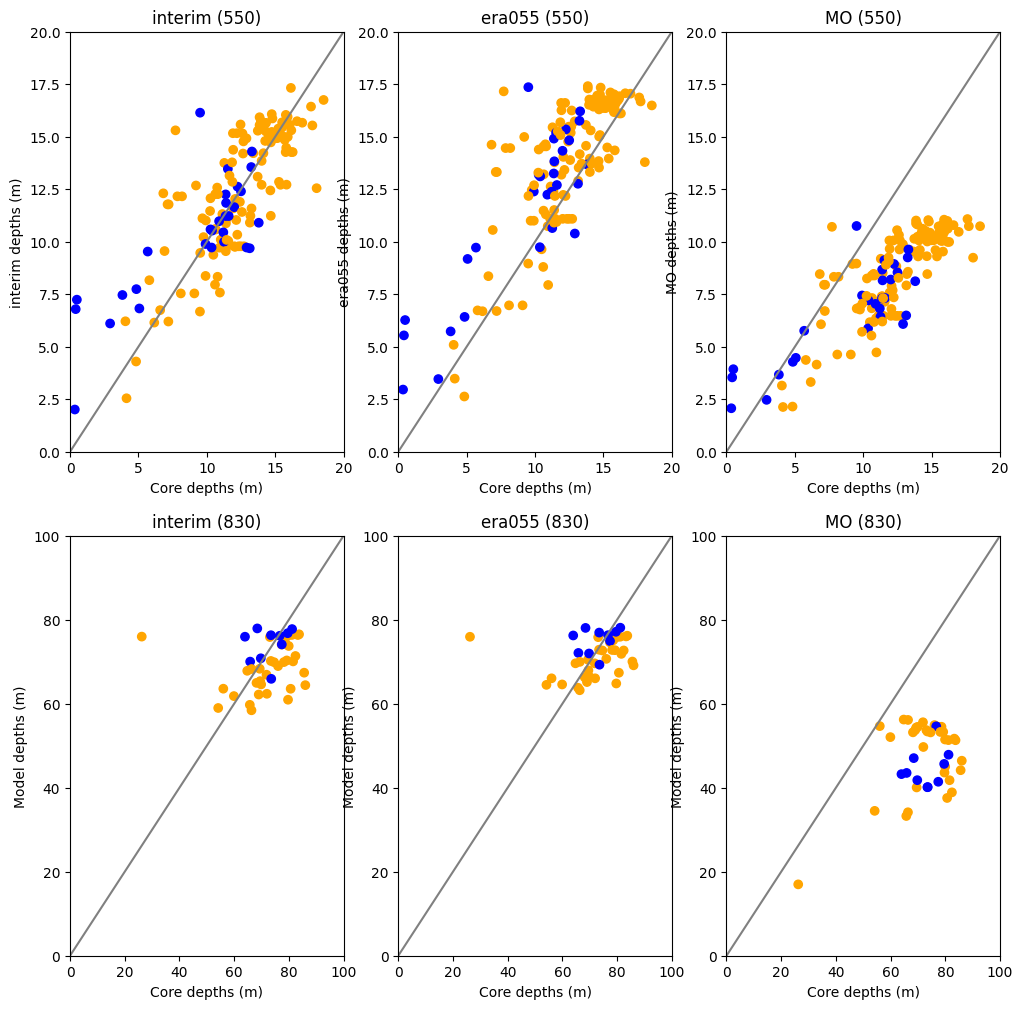

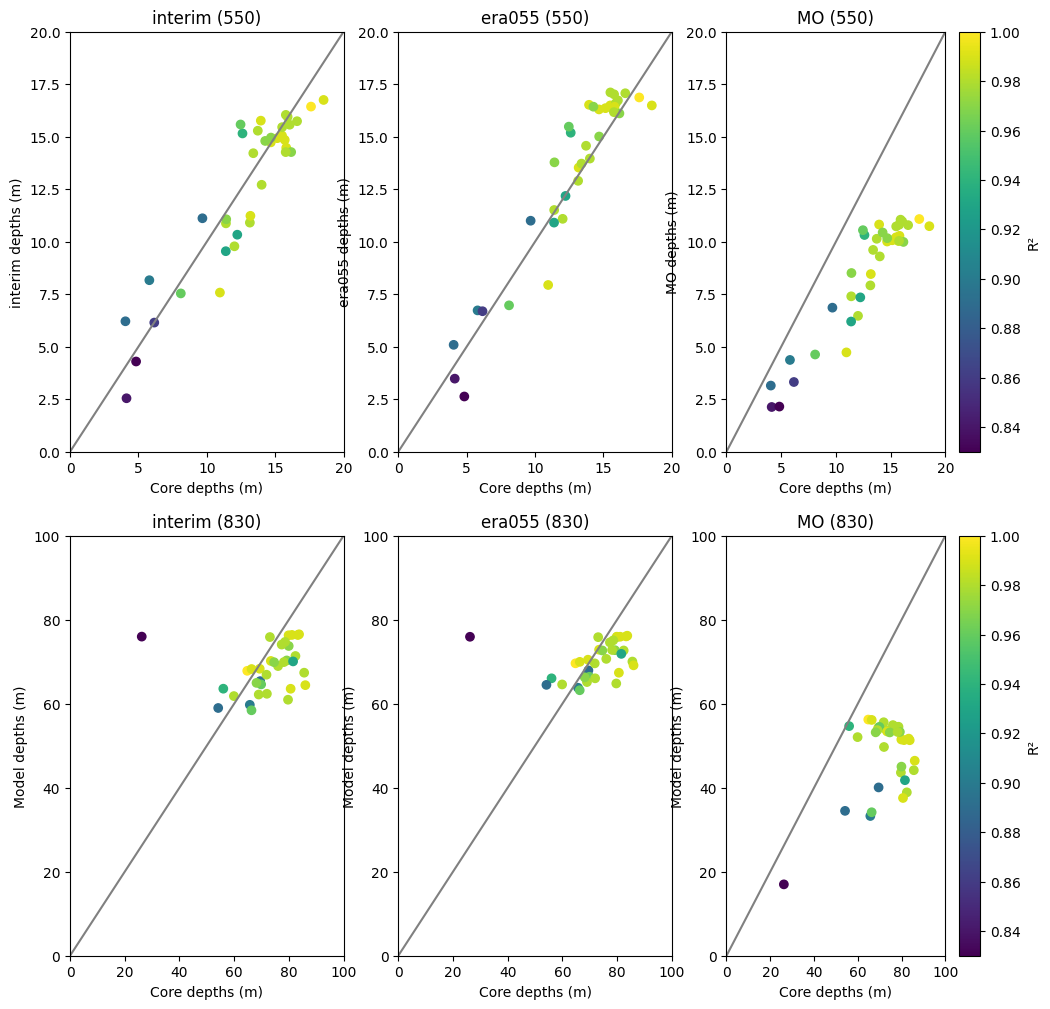

In [12]:
fig,axs=plt.subplots(2,3,figsize=(12,12))

only_PKM = merged_df[merged_df["source"]=='"PKM standardized cores"']

only_sumup = merged_df[merged_df["source"]=='SUMUP 2024']

x_1 = np.linspace(0,100,100)
y_1 = np.linspace(0,100,100)



for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[0,i].scatter(merged_df["depth_to_550"],merged_df[f"FDM_depth_to_550_{model_ver}"],c=merged_df["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')

    axs[1,i].scatter(merged_df["depth_to_830"], merged_df[f"FDM_depth_to_830_{model_ver}"],c=merged_df["source"].map({'PKM standardized cores':'blue','SUMUP 2024':'orange'}))
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

fig,axs=plt.subplots(2,3,figsize=(12,12))

for i, model_ver in enumerate(["interim", "era055", "MO"]):

    axs[0,i].scatter(merged_df["depth_to_550"],merged_df[f"FDM_depth_to_550_{model_ver}"],c=merged_df["r2"])
    axs[0,i].plot(x_1,y_1,color='grey')
    axs[0,i].set_title(f"{model_ver} (550)")
    axs[0,i].set_xlim([0,20])
    axs[0,i].set_ylim([0,20])
    axs[0,i].set_ylabel(f'{model_ver} depths (m)')
    axs[0,i].set_xlabel('Core depths (m)')
    

    axs[1,i].scatter(merged_df["depth_to_830"], merged_df[f"FDM_depth_to_830_{model_ver}"],c=merged_df["r2"])
    axs[1,i].plot(x_1,y_1,color='grey')
    axs[1,i].set_title(f"{model_ver} (830)")
    axs[1,i].set_xlim([0,100])
    axs[1,i].set_ylim([0,100])
    axs[1,i].set_ylabel('Model depths (m)')
    axs[1,i].set_xlabel('Core depths (m)')

plt.colorbar(axs[0,2].collections[0], ax=axs[0,2], label='R²')
plt.colorbar(axs[1,2].collections[0], ax=axs[1,2], label='R²')

               

## MO Fitting with Accumulation

Now we fit MO as a function of accumulation for both density regimes (550 and 830 kg/m³).

The approach:
1. Calculate optimal MO at each core location (MO that would make model match observations)
2. Fit MO as function of accumulation using forms from `firn_physics.f90`:
   - Low density (≤550): `MO = a + b*log(acav)`
   - High density (>550): `MO = a + b*log(acav)` or `MO = a * acav^b + c`

In [ ]:
def def_MO_models():
    # Define fitting functions for MO
    def mo_logarithmic(acav, a, b):
        """MO = a + b*log(acav)"""
        return a + b * np.log(acav)

    def mo_powerlog(acav, a, b, c):
        """MO = a * acav^b + c"""
        return a * (acav**b) + c
    
    models = [
        mo_powerlog,
        mo_logarithmic
    ]
    

    return models

def do_MO_fit(df_clean, df_type):

    """Performs MO fitting for both 550 and 830 kg/m³ density regimes.
    
    Parameters:
    df_clean (pandas.DataFrame): DataFrame containing core and modeled depths to 550 and 830.
    df_type (str): which model run to use ("interim", "era055", "MO").
    Returns:
    Dictionary of fit results for both density regimes.
    """

    df_clean['MO_optimal_550'] = df_clean[f'FDM_depth_to_550_{df_type}']/df_clean['depth_to_550'] 
    df_clean['MO_optimal_830'] = df_clean[f'FDM_depth_to_830_{df_type}']/df_clean['depth_to_830']

    # Remove unrealistic MO values (e.g., < 0.1 or > 5)
    df_clean = df_clean[(df_clean['MO_optimal_550'] > 0.1) & (df_clean['MO_optimal_550'] < 5.0)]
    df_clean = df_clean[(df_clean['MO_optimal_830'] > 0.1) & (df_clean['MO_optimal_830'] < 5.0)]

    mo_powerlog, mo_logarithmic = def_MO_models()


    
    # Perform fits for 830 density regime
    print("\n" + "="*60)
    print("FITTING MO FOR 550 kg/m³ DENSITY REGIME")
    print("="*60)

    # Logarithmic fit for 550
    popt_log_550, pcov_log_550 = curve_fit(mo_logarithmic, df_clean['avac'], df_clean['MO_optimal_550'])
    a_log_550, b_log_550 = popt_log_550
    MO_pred_log_550 = mo_logarithmic(df_clean['avac'], *popt_log_550)
    r2_log_550 = 1 - np.sum((df_clean['MO_optimal_550'] - MO_pred_log_550)**2) / np.sum((df_clean['MO_optimal_550'] - df_clean['MO_optimal_550'].mean())**2)
    rmse_log_550 = np.sqrt(np.mean((df_clean['MO_optimal_550'] - MO_pred_log_550)**2))

    print(f"\nLogarithmic fit: MO = {a_log_550:.4f} + {b_log_550:.4f}*log(acav)")
    print(f"  R² = {r2_log_550:.4f}")
    print(f"  RMSE = {rmse_log_550:.4f}")
    print(f"Current FGRN fit: MO = 0.6688 + 0.0048*log(acav)")

    # Perform fits for 830 density regime
    print("\n" + "="*60)
    print("FITTING MO FOR 830 kg/m³ DENSITY REGIME")
    print("="*60)


    df_clean_830 = df_clean[~df_clean['MO_optimal_830'].isna()]

    # Logarithmic fit for 830
    popt_log_830, pcov_log_830 = curve_fit(mo_logarithmic, df_clean_830['avac'], df_clean_830['MO_optimal_830'][~df_clean['MO_optimal_830'].isna()])
    a_log_830, b_log_830 = popt_log_830
    MO_pred_log_830 = mo_logarithmic(df_clean_830['avac'], *popt_log_830)
    r2_log_830 = 1 - np.sum((df_clean_830['MO_optimal_830'] - MO_pred_log_830)**2) / np.sum((df_clean_830['MO_optimal_830'] - df_clean_830['MO_optimal_830'].mean())**2)
    rmse_log_830 = np.sqrt(np.mean((df_clean_830['MO_optimal_830'] - MO_pred_log_830)**2))

    print(f"\nLogarithmic fit: MO = {a_log_830:.4f} + {b_log_830:.4f}*log(acav)")
    print(f"  R² = {r2_log_830:.4f}")
    print(f"  RMSE = {rmse_log_830:.4f}")
    print(f"Current FGRN fit: MO = 1.7465 - 0.2045*log(acav)")

    # Powerlog fit for 830


    popt_pow_830, pcov_pow_830 = curve_fit(mo_powerlog, df_clean_830['avac'], df_clean_830['MO_optimal_830'], p0=[1, -0.6, 1], maxfev = 2000)
    a_pow_830, b_pow_830, c_pow_830 = popt_pow_830
    MO_pred_pow_830 = mo_powerlog(df_clean_830['avac'], *popt_pow_830)
    r2_pow_830 = 1 - np.sum((df_clean_830['MO_optimal_830'] - MO_pred_pow_830)**2) / np.sum((df_clean_830['MO_optimal_830'] - df_clean_830['MO_optimal_830'].mean())**2)
    rmse_pow_830 = np.sqrt(np.mean((df_clean_830['MO_optimal_830'] - MO_pred_pow_830)**2))

    print(f"\nPowerlog fit: MO = {a_pow_830:.4f} * acav^{b_pow_830:.4f} + {c_pow_830:.4f}")
    print(f"  R² = {r2_pow_830:.4f}")
    print(f"  RMSE = {rmse_pow_830:.4f}")
    print(f"Current ANT27 powerlog: MO = 6.387 * acav^(-0.477) + 0.195")

    fit_results = {
        'log_550': (popt_log_550, MO_pred_log_550, r2_log_550, rmse_log_550),
        'log_830': (popt_log_830, MO_pred_log_830, r2_log_830, rmse_log_830),
        'pow_830': (popt_pow_830, MO_pred_pow_830, r2_pow_830, rmse_pow_830)
        }
    
    return fit_results

def plot_MO_fits(df_clean, fit_results):

    mo_logarithmic, mo_powerlog = def_MO_models()
    df_clean_830 = df_clean[~df_clean['MO_optimal_830'].isna()]

    popt_log_550, MO_pred_log_550, r2_log_550 = fit_results['log_550']
    popt_log_830, MO_pred_log_830, r2_log_830 = fit_results['log_830']
    popt_pow_830, MO_pred_pow_830, r2_pow_830 = fit_results['pow_830']
     
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Generate smooth curves for plotting
    acav_range = np.linspace(df_clean['avac'].min(), df_clean['avac'].max(), 200)

    spy = 3600*24*365.25

    # Current FGRN fits for comparison
    MO_current_550 = 0.6688 + 0.0048 * np.log(acav_range*spy)
    MO_current_830 = 1.7465 - 0.2045 * np.log(acav_range*spy)

    # Plot 550 results
    ax1 = axes[0, 0]
    ax1.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'], alpha=0.5, s=20, label='Data', color='gray')
    ax1.plot(acav_range*spy, mo_logarithmic(acav_range, *popt_log_550), 'b-', linewidth=2, 
            label=f'Log fit (R²={r2_log_550:.3f})')
    #ax1.plot(acav_range*spy, mo_powerlog(acav_range, *popt_pow_550), 'r-', linewidth=2, 
    #         label=f'Power fit (R²={r2_pow_550:.3f})')
    ax1.plot(acav_range*spy, MO_current_550, 'k--', linewidth=1.5, alpha=0.7, label='Current FGRN')
    ax1.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
    ax1.set_ylabel('MO', fontsize=11)
    ax1.set_title('MO Fits for 550 kg/m³ Density', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot 830 results
    ax2 = axes[0, 1]
    ax2.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'], alpha=0.5, s=20, label='Data', color='gray')
    ax2.plot(acav_range*spy, mo_logarithmic(acav_range, *popt_log_830), 'b-', linewidth=2, 
            label=f'Log fit (R²={r2_log_830:.3f})')
    ax2.plot(acav_range*spy, mo_powerlog(acav_range, *popt_pow_830), 'r-', linewidth=2, 
            label=f'Power fit (R²={r2_pow_830:.3f})')
    ax2.plot(acav_range*spy, MO_current_830, 'k--', linewidth=1.5, alpha=0.7, label='Current FGRN')
    ax2.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
    ax2.set_ylabel('MO', fontsize=11)
    ax2.set_title('MO Fits for 830 kg/m³ Density', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # Residual plots for 550
    ax3 = axes[1, 0]
    ax3.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'] - MO_pred_log_550, 
            alpha=0.5, s=15, label='Log residuals', color='blue')
    #ax3.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'] - MO_pred_pow_550, 
    #           alpha=0.5, s=15, label='Power residuals', color='red')
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
    ax3.set_ylabel('Residuals', fontsize=11)
    ax3.set_title('Residuals for 550 kg/m³', fontsize=12)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # Residual plots for 830
    ax4 = axes[1, 1]
    ax4.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'] - MO_pred_log_830, 
            alpha=0.5, s=15, label='Log residuals', color='blue')
    ax4.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'] - MO_pred_pow_830, 
            alpha=0.5, s=15, label='Power residuals', color='red')
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax4.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
    ax4.set_ylabel('Residuals', fontsize=11)
    ax4.set_title('Residuals for 830 kg/m³', fontsize=12)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    

In [16]:
PKM_fit_results = do_MO_fit(only_PKM)
plot_MO_fits(only_PKM, PKM_fit_results)


FITTING MO FOR 550 kg/m³ DENSITY REGIME


ValueError: `ydata` must not be empty!

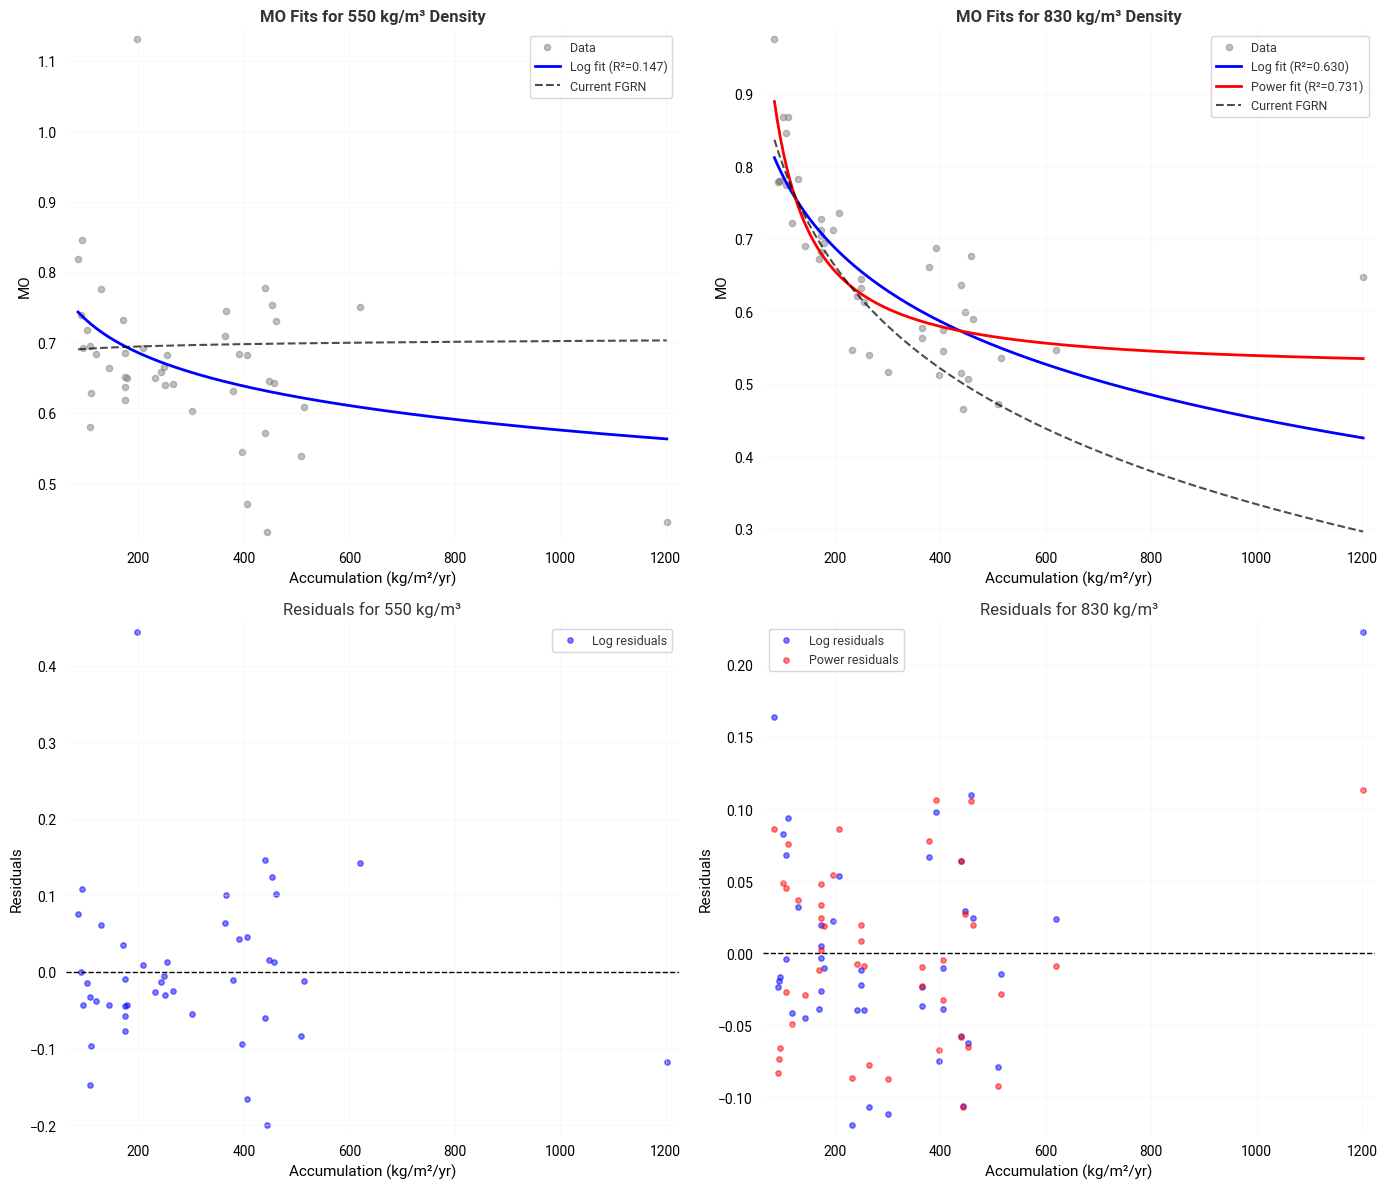

In [ ]:
# Create visualization comparing fits
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Generate smooth curves for plotting
acav_range = np.linspace(df_clean['avac'].min(), df_clean['avac'].max(), 200)

spy = 3600*24*365.25

# Current FGRN fits for comparison
MO_current_550 = 0.6688 + 0.0048 * np.log(acav_range*spy)
MO_current_830 = 1.7465 - 0.2045 * np.log(acav_range*spy)



# Plot 550 results
ax1 = axes[0, 0]
ax1.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'], alpha=0.5, s=20, label='Data', color='gray')
ax1.plot(acav_range*spy, mo_logarithmic(acav_range, *popt_log_550), 'b-', linewidth=2, 
         label=f'Log fit (R²={r2_log_550:.3f})')
#ax1.plot(acav_range*spy, mo_powerlog(acav_range, *popt_pow_550), 'r-', linewidth=2, 
#         label=f'Power fit (R²={r2_pow_550:.3f})')
ax1.plot(acav_range*spy, MO_current_550, 'k--', linewidth=1.5, alpha=0.7, label='Current FGRN')
ax1.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
ax1.set_ylabel('MO', fontsize=11)
ax1.set_title('MO Fits for 550 kg/m³ Density', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 830 results
ax2 = axes[0, 1]
ax2.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'], alpha=0.5, s=20, label='Data', color='gray')
ax2.plot(acav_range*spy, mo_logarithmic(acav_range, *popt_log_830), 'b-', linewidth=2, 
         label=f'Log fit (R²={r2_log_830:.3f})')
ax2.plot(acav_range*spy, mo_powerlog(acav_range, *popt_pow_830), 'r-', linewidth=2, 
         label=f'Power fit (R²={r2_pow_830:.3f})')
ax2.plot(acav_range*spy, MO_current_830, 'k--', linewidth=1.5, alpha=0.7, label='Current FGRN')
ax2.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
ax2.set_ylabel('MO', fontsize=11)
ax2.set_title('MO Fits for 830 kg/m³ Density', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Residual plots for 550
ax3 = axes[1, 0]
ax3.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'] - MO_pred_log_550, 
           alpha=0.5, s=15, label='Log residuals', color='blue')
#ax3.scatter(df_clean['avac']*spy, df_clean['MO_optimal_550'] - MO_pred_pow_550, 
#           alpha=0.5, s=15, label='Power residuals', color='red')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.set_title('Residuals for 550 kg/m³', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Residual plots for 830
ax4 = axes[1, 1]
ax4.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'] - MO_pred_log_830, 
           alpha=0.5, s=15, label='Log residuals', color='blue')
ax4.scatter(df_clean_830['avac']*spy, df_clean_830['MO_optimal_830'] - MO_pred_pow_830, 
           alpha=0.5, s=15, label='Power residuals', color='red')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Accumulation (kg/m²/yr)', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('Residuals for 830 kg/m³', fontsize=12)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.savefig("../figures/MO_fits_all_550_830.png", dpi=300)